In [1]:
# A/B testing propsal

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data
import datetime as dt
from datetime import datetime



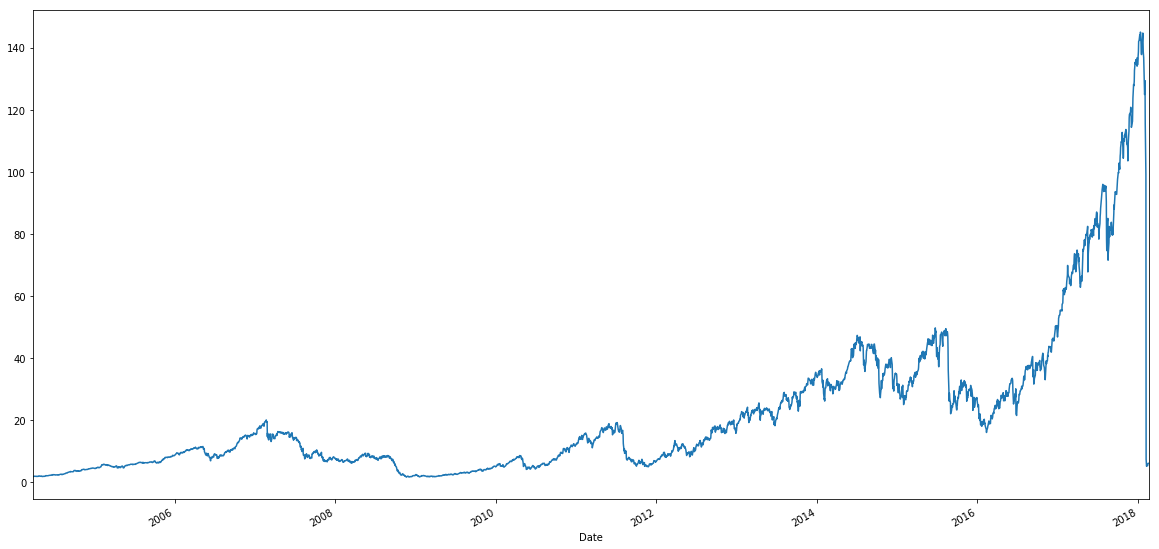

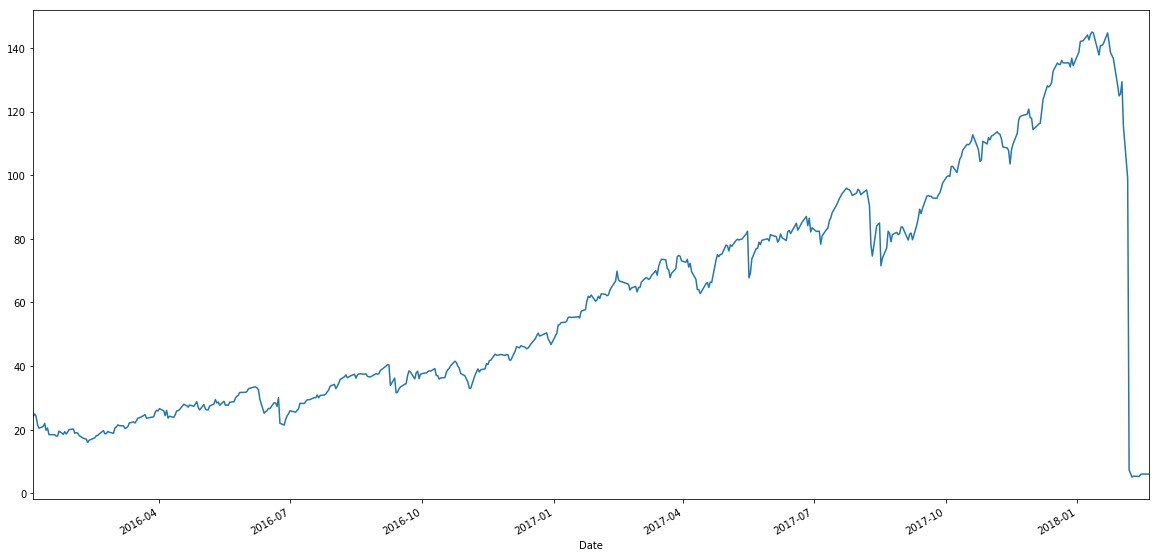

In [2]:
# get XIV from a public dropbox -- XIV had a termination event Feb. 5 2018, so this is archived data.

xiv = pd.read_csv("https://dl.dropboxusercontent.com/s/jk6der1s5lxtcfy/XIVlong.TXT", parse_dates=True, index_col=0)

# get SVXY data from Yahoo finance
svxy = data.DataReader('SVXY', 'yahoo', '2016-01-01')
#yahoo_xiv = data.DataReader('XIV', 'yahoo', '1990-01-01')

# yahoo no longer carries XIV because the instrument blew up, need to find it from historical sources
xiv_returns = xiv['Close'].pct_change()
svxy_returns = svxy['Close'].pct_change()

xiv['Close'].plot(figsize=(20,10))
plt.show()
xiv['2016':'2018']['Close'].plot(figsize=(20,10))

In [3]:
# get formatted SVIX data from my dropbox (CBOE has it in a mess)

svix = pd.read_csv("https://www.dropbox.com/s/u8qiz7rh3rl7klw/SHORTVOL_Data.csv?raw=1", header = 0, parse_dates = True, index_col = 0)
svix.columns = ["Open", "High", "Low", "Close"]
svix_rets = svix['Close'].pct_change()

In [4]:
# put data set together

xiv_svxy = pd.concat([xiv_returns[:'2018-02-07'],svxy_returns['2018-02-08':]], axis = 0)
xiv_svxy_svix = pd.concat([xiv_svxy, svix_rets], axis = 1).dropna()
xiv_svxy_svix.tail()

final_data = xiv_svxy_svix
final_data.columns = ["XIV_SVXY", "SVIX"]
final_data.head()

,XIV_SVXY,SVIX
Date,,
2005-12-22,0.008353,0.010486
2005-12-23,0.020118,0.018990
2005-12-27,-0.017401,-0.007910
2005-12-28,0.009445,0.000184
2005-12-29,0.000000,0.006852


Research proposal: there are plans for a new ETF that expresses the idea of a -1x exposure to short volatility, similar to what the old XIV ETF did. However, the old XIV ETF suffered a termination event--losing approximately 95% over the course of a day on February 5th, with most of those losses ocurring after hours within 20 minutes after 4 PM. A new proposed ETF, SVIX, created by VolatilityShares, aims to solve that problem, by tracking the SHORTVOL index.

Data for XIV, including synthetically, can be found on a publicly available dropbox link, while data for SVXY--a surviving short volatility ETF that went to 50% leverage, can be downloaded from Yahoo Finance. Lastly, hypothetical performance for SVIX, formatted, is downloaded from my own dropbox. However, it can also be found here: http://www.cboe.com/index/dashboard/SHORTVOL#shortvol-performance 

The business question that's posed here is whether or not the new SVIX ETF is a more viable instrument than the XIV ETF. While the answer is that it most likley is, as the collapse of XIV motivated its design in the first place, the goal of this experiment is to prove, statistically, that the new SVIX instrument outperforms the XIV into SVXY instrument that current volatility traders (such as myself) currently use for their trading strategies.  A good hypothesis to test, for starters, is whether or not the average daily return of SVIX is greater than that of XIV into SVXY. Additionally, a test of rolling volatility can be done as well, though that should not be necessary.

The relevant stakeholders for this analysis are volatility traders such as myself, and other individuals that trade volatility-based strategies as diversifiers to other, more traditional investments such as index funds (E.G. SPY, TLT, etc.). The benefit to such individuals will be to see if there is a new viable short volatility instrument that has 100% short volatility exposure like XIV used to provide. Certainly, as someone who actively trades a strategy that traded XIV and now trades SVXY, this is especially pertinent to me, and definitely some of my blog readers, along with the fund in which I have an RIA investment.

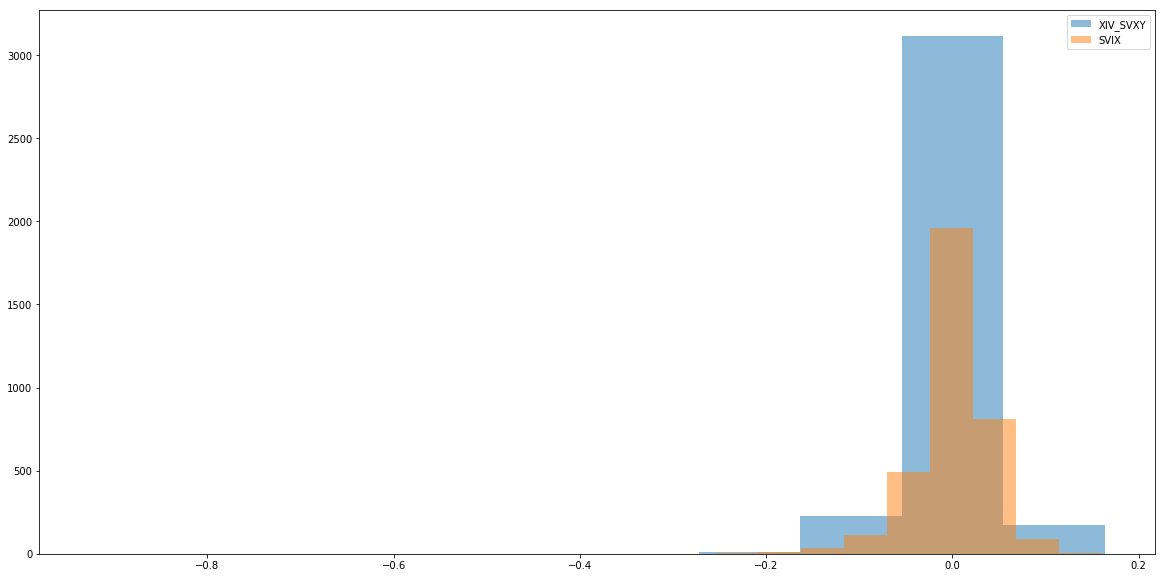

DescribeResult(nobs=3527, minmax=(-0.9257575757575758, 0.1635036496350366), mean=0.0011627123490346562, variance=0.0015918321320673623, skewness=-4.325358554250933, kurtosis=85.06927230848028)
DescribeResult(nobs=3527, minmax=(-0.3011955533480766, 0.16095949898733686), mean=0.0015948970447533636, variance=0.0015014216189676208, skewness=-1.0811171524703087, kurtosis=4.453114992142524)
DescribeResult(nobs=10000, minmax=(-3.2850716341455586, 3.9005616358767594), mean=0.0020330585753520303, variance=1.0086732436990518, skewness=-0.004846491532598354, kurtosis=-0.0707495743321136)


In [5]:
# CHECKPOINT APPROVED -- BEGIN HYPOTHESIS TESTING FROM HERE

plt.figure(figsize=(20,10))
plt.hist(final_data['XIV_SVXY'], alpha = .5)
plt.hist(final_data['SVIX'], alpha = .5)
plt.legend(final_data)
plt.show()

# X axis shows that data is clearly abnormal--and I know from personal experience
# that these instruments are *extremely* abnormal.

print(stats.describe(final_data['XIV_SVXY']))
print(stats.describe(final_data['SVIX']))
print(stats.describe(np.random.normal(size=10000)))

The descriptions for the distributions of the returns of these instruments are both *EXTREMELY* non-normal. Not only are they non-normal, but they're non-normal in the bad kind of way (which is what makes trading difficult): they have high kurtosis (a staggeringly high 85 for the XIV-SVXY, but also a 4.4 excess kurtosis for SVIX), along with noticeable left skew (-4 for the former, -1 for the latter). Therefore, any statistical test for normally distributed variables is not valid.

Additionally, the Shapiro-Wilk test for normality would certainly reject the possibility of normally-distributed data, as larger sample sizes would cause the test to reject, but from simply eyeballing the histogram, and descriptive statistics that the data is very non-normal. Additionally, trading intuition also states that financial returns are often heavy-tailed and can be prone to large and fast drawdowns.  

However, that's certainly a possibility to examine for the sake of meticulousness. Additionally, depending on how one chooses to view the relationships between the two instruments -- either two independent ETFs that would justify the Kruskal-Wallis test, or two ETFs expressing the same investment idea (short exposure to short-term volatility that XIV used to express that SVXY currently does), which would justify the Wilcoxon signed rank test.

In [6]:


print(stats.shapiro(final_data['XIV_SVXY']))
print(stats.shapiro(final_data['SVIX']))

(0.8305274844169617, 0.0)
(0.9374037981033325, 3.353862811944423e-36)


As expected from visual inspection, intuition about financial markets, and personal trading experience, the data here is extremely non-normal.

Let's do some hypothesis tests. First off, it's worth trying the Kruskal-Wallis test. The null hypothesis is that the two products are not distinguishably different, while the alternative hypothesis would show that SVIX has statistically significantly better properties.

In [7]:
stats.kruskal(final_data['SVIX'], final_data['XIV_SVXY'])


KruskalResult(statistic=0.8613306385456933, pvalue=0.3533665896055551)

Interestingly enough, the Kruskal-Wallis test does not find a statistically significant difference between these two products. However: this actually does make sense when one thinks about the actual calculation of the Kruskal-Wallis test, as ultimately, the Kruskal-Wallis test does not compare actual values, but rather, the *rank* of the values. So, even though SVIX manages to solve the problem of the massive outlier that destroyed XIV, in both instances, the rank of the massive "volpocalypse" that occurred on Feb. 5th after hours is going to take a similar rank as "the worst day ever" between these two return streams. An analogous argument can be made for other particularly bad days--that so long as the two investment products are supposed to go up or down based upon identical dynamics, it makes intuitive sense that a test not taking into account absolute magnitude of the returns will fail to reject the hypothesis that SVIX is a better product than the XIV/SVXY combo.

Approaching the topic from another perspective in that SVIX is supposed to serve an identical, but improved purpose to XIV, one can perform the Wilcoxon signed-rank test testing the same hypothesis as before, with the null hypothesis of no difference between the XIV -> SVXY combo, and the alternative hypothesis that there is a material difference between the two.

In [8]:
stats.wilcoxon(final_data['SVIX'], final_data['XIV_SVXY'])

WilcoxonResult(statistic=2947901.0, pvalue=0.0070668195307847575)

In the case of the Wilcoxon test, we have a test significant not just at the 5% level, but at the 1% level. As the purposes of the two instruments are identical, it makes sense to compare them as the same instrument, and conduct a test of differences.

One other way to visualize the difference in instruments is with a pair of boxplots. 

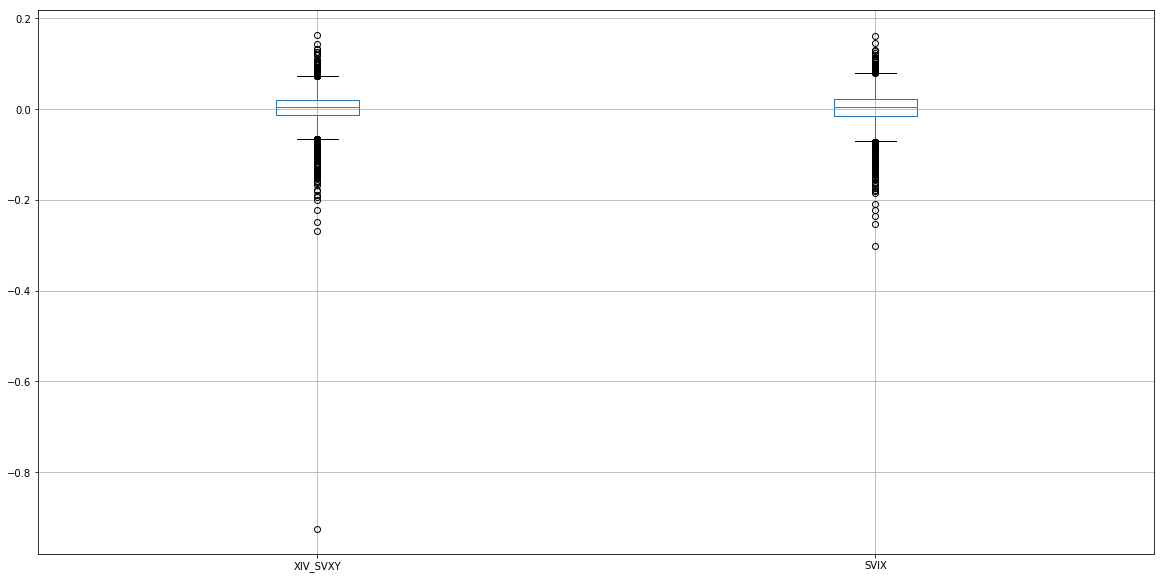

In [9]:

final_data.boxplot(figsize=(20,10))


As can be seen, there are some fairly large down days in these instruments--including one day in XIV that destroyed the instrument prompting the shift to SVXY instead. SVIX has solved that issue. In the following time series return plot, one can visualize the daily differences between the two instruments, subtracting the existing instrument's daily returns (XIV/SVXY at 50% leverage) from the proposed instrument.


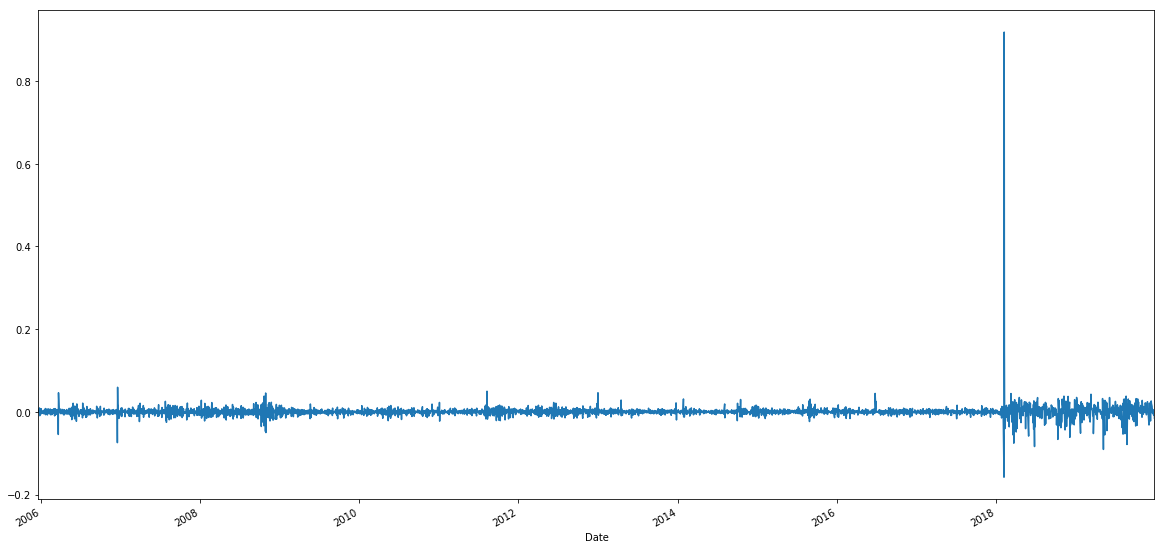

In [10]:
diff_data = final_data['SVIX'] - final_data['XIV_SVXY']
diff_data.plot(figsize=(20,10))

One last thing to look at, in my opinion, is the P-value of the Wilcoxon text over the course of time. Ideally, what it should reflect is that there should be fairly little distinguishment between the two instruments until the day of XIV's destruction in February of 2018, which prompted the design of the instrument.

What follows is an endpoints function that I created and posted on my blog, at this URL: https://quantstrattrader.wordpress.com/2019/12/16/a-tale-of-an-edgy-panda-and-some-python-reviews/ that is able to find the last endpoint--that is, trading day--of a week, month, quarter, or year, to allow for an efficient method for looping through and subsetting a time series, which functions analogously to R's endpoints function from the very-well iterated xts package.

I use that function to loop through 12-month subsets in the comparison data between the two instruments, performing a Wilcoxon test each time, and noting the p-value, and the ending date of the data subset that it belongs to. Lastly, I plot the p-values of said Wilcoxon test.

In [11]:
# endpoints function

def endpoints(df, on = "M", offset = 0):
    """
    Returns index of endpoints of a time series analogous to R's endpoints
    function. 
    Takes in: 
        df -- a dataframe/series with a date index
         
        on -- a string specifying frequency of endpoints
         
        (E.G. "M" for months, "Q" for quarters, and so on)
         
        offset -- to offset by a specified index on the original data
        (E.G. if the data is daily resolution, offset of 1 offsets by a day)
        This is to allow for timing luck analysis. Thank Corey Hoffstein.
    """
     
    # to allow for familiarity with R
    # "months" becomes "M" for resampling
    if len(on) > 3:
        on = on[0].capitalize()
     
    # get index dates of formal endpoints
    ep_dates = pd.Series(df.index, index = df.index).resample(on).max()
     
    # get the integer indices of dates that are the endpoints
    date_idx = np.where(df.index.isin(ep_dates))
     
    # append zero and last day to match R's endpoints function
    # remember, Python is indexed at 0, not 1
    date_idx = np.insert(date_idx, 0, 0)
    date_idx = np.append(date_idx, df.shape[0]-1)
    if offset != 0:
        date_idx = date_idx + offset
        date_idx[date_idx < 0] = 0
        date_idx[date_idx > df.shape[0]-1] = df.shape[0]-1
    out = np.unique(date_idx)
    return out   

ep = endpoints(final_data)

2017-07-28    0.902533
2017-08-30    0.894971
2017-09-28    0.685495
2017-10-30    0.793093
2017-11-29    0.951521
2017-12-28    0.890546
2018-01-30    0.721118
2018-02-27    0.561795
2018-03-28    0.464851
2018-04-27    0.900470
2018-05-30    0.595646
2018-06-28    0.405771
2018-07-30    0.228674
2018-08-30    0.132506
2018-09-27    0.085125
2018-10-30    0.249457
2018-11-29    0.230020
2018-12-28    0.522734
2019-01-30    0.224727
2019-02-27    0.055854
2019-03-28    0.034665
2019-04-29    0.019178
2019-05-30    0.065563
2019-06-27    0.071348
2019-07-30    0.056757
2019-08-29    0.129120
2019-09-27    0.148046
2019-10-30    0.014340
2019-11-27    0.006139
2019-12-26    0.000558
dtype: float64

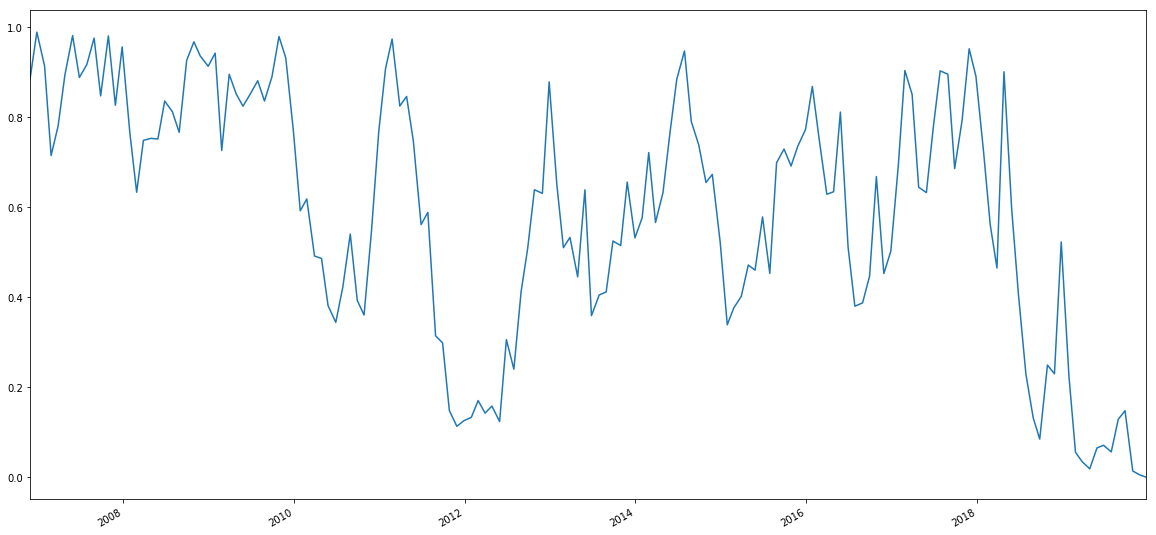

In [12]:
dates = []
pvals = []
for i in range(0, (len(ep)-12)):
  data_subset = final_data.iloc[(ep[i]+1):ep[i+12]]
  pval = stats.wilcoxon(data_subset['SVIX'], data_subset['XIV_SVXY'])[1]
  date = data_subset.index[-1]
  dates.append(date)
  pvals.append(pval)
wilcoxTS = pd.Series(pvals, index = dates)
wilcoxTS.plot(figsize=(20,10))

wilcoxTS.tail(30)

Looking at the last 30 months, along with the plot of the Wilcoxon p-values, it seems that the p-values completely drop out about a year after the crash, as that's when the old XIV data completely washes out, and is replaced entirely by SVXY, which only has a 50% exposure to short vol, rather than the -1 that XIV used to provide. Considering that the Wilcoxon test examines whether or not the median difference of a distribution is statistically significantly different from zero, and that financial returns are extremely noisy, it does make sense that it may take some time for the Wilcoxon test to detect a significant difference in the difference of return distributions, given only a data set of approximately 250 points.

What's most noteworthy, however, is how the P-value drops off drastically in recent times and remains exceptionally low.

As far as biases are concerned, there may have been an element of HARKing (Hypothesizing After Results Known) involved in this data comparison, as the fact that XIV blew up is objective history, and SVIX was designed to be a different instrument from the 50% exposed SVXY that replaced it. This experiment, therefore, was more of a confirmatory experiment than anything else.  

# Questions?
